In [82]:
source('R/experiment.R')
source('R/dgp.R')
source('R/power.R')

trial_configs = list(
  null = list(const_effect=TRUE, zeta=0),
  additive = list(const_effect=TRUE, zeta=0.2),
  hetero = list(const_effect=FALSE, zeta=0.04)
)

hist_shifts = list(
  no_shift = list(),
  shift_obs_small = list(shift_W1=1.5),
  shift_obs_large = list(shift_W1=3),
  shift_unobs_small = list(shift_U=1.5),
  shift_unobs_large = list(shift_U=3)
)

SCENARIOS = list()
for (t_name in names(trial_configs)) {
  t_args = trial_configs[[t_name]]
  trial_dgp = do.call(dgp, t_args)
  
  for (h_name in names(hist_shifts)) {
    h_args = hist_shifts[[h_name]]
    # Combine trial args with shift args
    # Use modifyList to merge arguments, allowing shifts to override if necessary
    hist_args = utils::modifyList(t_args, h_args)
    hist_dgp = do.call(dgp, hist_args)
    
    name = paste(t_name, h_name, sep = "-")
    SCENARIOS[[name]] = list(
      trial = trial_dgp,
      hist = hist_dgp
    )
  }
}

In [83]:
N_HIST = 2500
REPS = 1000

# target_scenarios = c("null-no_shift", "additive-no_shift", "hetero-no_shift")

results_list = names(SCENARIOS) |> 
  map(function(scenario_name) {
    s = SCENARIOS[[scenario_name]]
    HIST = s$hist
    TRIAL = s$trial
    
    true_rr = RR(TRIAL)
    
    1:REPS |> furrr::future_map(
      \(rep) {
        draw.dgp # Force export of S3 method
    
        c(lrnr_results, power_stats, lrnr) %<-% fit_prog(HIST, N_HIST, mu_wf=MU_WF)
    
        list(
          estimates = seq(100,400,by=50) |> map_df(\(n_trial) {
            analyze_trial(TRIAL, n_trial, lrnr, cv=F) |>
            mutate(
              n_hist = N_HIST,
              n_trial = n_trial,
            )
          }),
          n_power = sample_sizes(true_rr, power_stats)
        )
    
      },
      .options = furrr::furrr_options(seed = 3021377)
    ) |> 
      list_transpose() |>
      map(bind_rows, .id = 'rep') %->%
      c(estimates_local, n_power_local)
    
    list(
        estimates = estimates_local |> 
          mutate(
            scenario = scenario_name, 
            true_rr = true_rr
          ),
        n_power = n_power_local |> mutate(scenario = scenario_name)
    )
  })

plot_data = results_list |> map("estimates") |> bind_rows()
power_summary = results_list |> map("n_power") |> bind_rows() 

write_rds(list(plot_data, power_summary), 'outputs/datasets/power-nocv.rds')

There were 50 or more warnings (use warnings() to see the first 50)


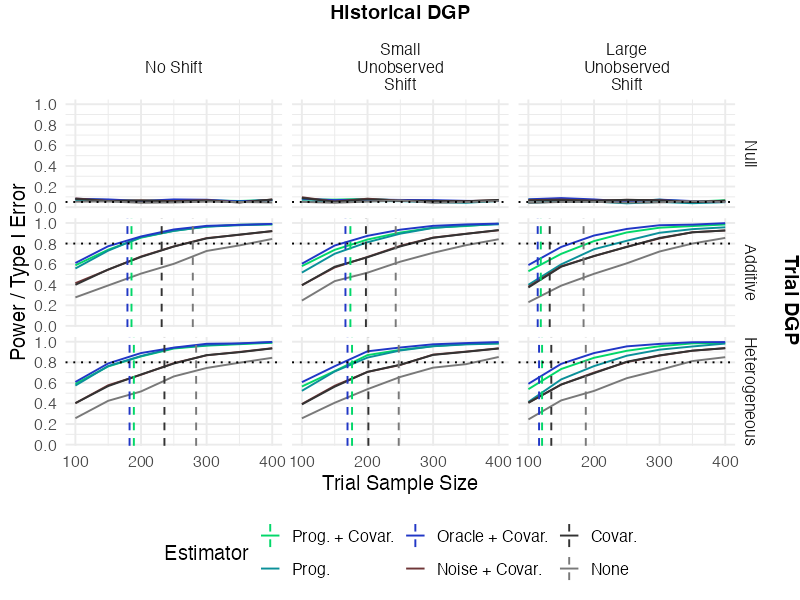

In [84]:
# c(plot_data, power_summary) %<-% read_rds('outputs/datasets/power.rds')

source('R/plotting_utils.R')

plot_data_formatted = plot_data |>
  report() |>
  format_scenario_data() |>
  filter(hist_type %in% c("no_shift", "shift_unobs_small", "shift_unobs_large")) |>
  mutate(estimator = format_estimator(estimator))
  
power_summary_formatted = power_summary |>
  group_by(scenario, estimator) |>
  summarize(n = mean(n), .groups="drop") |>
  format_scenario_data() |>
  filter(hist_type %in% c("no_shift", "shift_unobs_small", "shift_unobs_large")) |>
  mutate(estimator = format_estimator(estimator))|>
  filter(!str_detect(scenario, "^null"))

# Define horizontal lines for each scenario
hline_data = plot_data_formatted |>
  distinct(scenario, `trial DGP`, `modification for historical DGP`) |>
  mutate(yintercept = ifelse(str_detect(scenario, "^null"), 0.05, 0.8))

p = plot_data_formatted |>
  ggplot(aes(x=n_trial, y=pct_significant, color=estimator)) +
  geom_line() +
  geom_vline(data = power_summary_formatted, aes(xintercept = n, color = estimator), linetype = "dashed") +
  geom_hline(data = hline_data, aes(yintercept = yintercept), linetype="dotted", color='black') +
  facet_grid(
      `trial DGP` ~ `modification for historical DGP`,
       labeller = labeller(`modification for historical DGP` = label_wrap_gen(width = 14))
  ) +
  scale_color_manual(values = plot_colors) +
  scale_y_continuous(breaks = seq(0, 1, by = 0.2)) +
  theme_minimal(base_size = 15) +
  theme(legend.position = "bottom") +
  labs(
    x = "Trial Sample Size",
    y = "Power / Type I Error",
    color = "Estimator"
  )

library(cowplot)

p_final = ggdraw() +
  draw_plot(p, x = 0, y = 0, width = 0.97, height = 0.96) +
  draw_label("Historical DGP", x = 0.5, y = 0.98, fontface = "bold", size = 15) +
  draw_label("Trial DGP", x = 0.99, y = 0.5, angle = 270, fontface = "bold", size = 15)

ggsave("outputs/plots/power-nocv.png", p_final, width = 12, height = 8, dpi = 300, bg = "white")
p_final

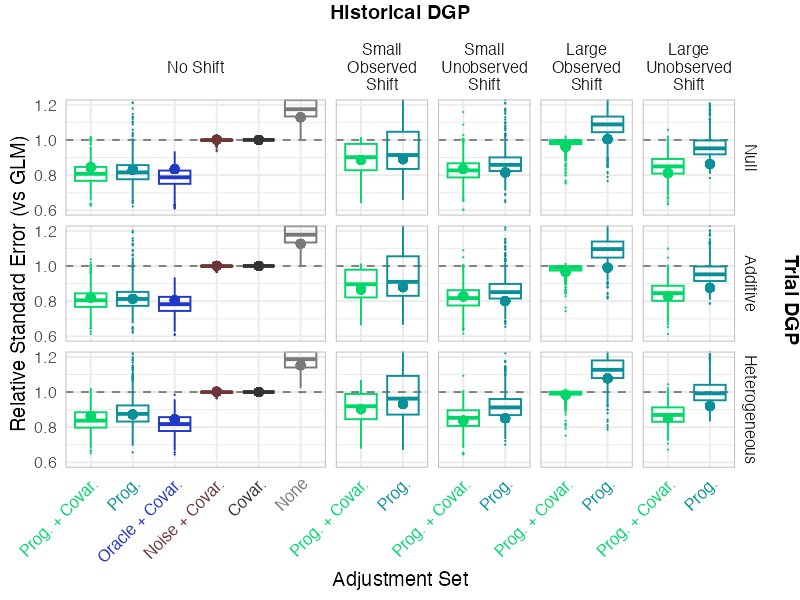

In [85]:
source('R/plotting_utils.R')

# Prepare base data
base_data =  plot_data |> 
  filter(n_trial == 250) |>
  format_scenario_data()

# Calculate Estimated Relative SE (per rep)
plot_data_est = base_data |>
  group_by(rep, trial_type, hist_type) |>
  mutate(
    ref_se = `Std. Error`[estimator == "GLM"],
    rel_se_est = `Std. Error` / ref_se
  ) |>
  ungroup()

# Calculate True Relative SE (aggregated)
true_stats = base_data |>
  group_by(estimator, trial_type, hist_type) |>
  summarise(true_se = sd(Estimate, na.rm = TRUE), .groups = "drop") |>
  group_by(trial_type, hist_type) |>
  mutate(
    ref_true_se = true_se[estimator == "GLM"],
    rel_se_true = true_se / ref_true_se
  ) |>
  ungroup()

# Merge, Format, and Filter
plot_data_2 = plot_data_est |>
  left_join(true_stats, by = c("estimator", "trial_type", "hist_type")) |>
  mutate(
    estimator = format_estimator(estimator),
    # Meta-labels for faceting
    `Trial DGP Label` = "Trial DGP:",
    `Mod Label` = "Modification for Historical DGP:"
  ) |>
    # Filter out redundant estimators for shift scenarios
  filter(
    !(`modification for historical DGP` != "No Shift" & 
      !estimator %in% c("Prog. + Covar.", "Prog."))
  )

library(cowplot)

# Ensure we have colors for all levels, defaulting to black if missing
colors_vec <- plot_colors[levels(plot_data_2$estimator)]
colors_vec[is.na(colors_vec)] <- "black"

p = plot_data_2 |>
  ggplot(aes(x=estimator, color=estimator)) +
  geom_hline(yintercept = 1, linetype = "dashed", color = "gray50") +
  geom_boxplot(aes(y=rel_se_est), fill=NA, outlier.size=0.2) +
  geom_point(aes(y=rel_se_true), shape=19, size=2.5) +
  facet_grid(
    `trial DGP` ~ `modification for historical DGP`,
    scales = "free_x", 
    space = "free_x",
    labeller = labeller(`modification for historical DGP` = label_wrap_gen(width = 14))
  ) +
  coord_cartesian(ylim = c(0.6, 1.2)) +
  scale_color_manual(values = plot_colors) +
  labs(
    y = "Relative Standard Error (vs GLM)",
    x = "Adjustment Set",
    color = NULL
  ) +
  theme_minimal(base_size = 15) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, color=colors_vec),
    panel.border = element_rect(color = "grey", fill = NA),
    legend.position = "none"
  )

# Add custom labels using cowplot
p_final = ggdraw() +
  draw_plot(p, x = 0, y = 0, width = 0.97, height = 0.96) +
  draw_label("Historical DGP", x = 0.5, y = 0.98, fontface = "bold", size = 15) +
  draw_label("Trial DGP", x = 0.99, y = 0.5, angle = 270, fontface = "bold", size = 15)

ggsave("outputs/plots/se-nocv.png", p_final, width = 12, height = 8, dpi = 300, bg = "white")
p_final

In [ ]:
trial = dgp(const_effect = T, zeta=0.2)
c(lrnr_results, power_stats, lrnr) %<-% fit_prog(trial, 5000, mu_wf=MU_WF)
as_tibble(power_stats) |>
  mutate(rr= RR(trial))

# A tibble: 1 × 6
   psi0 sigma2 kappa_oracle kappa_ml kappa_glm    rr
  <dbl>  <dbl>        <dbl>    <dbl>     <dbl> <dbl>
1  4.59   8.81         2.02     2.06      2.59  1.22

In [78]:
trial = dgp(const_effect = T, zeta=0.2)
r2(trial, 1e5)

$r2
[1] 0.7681

$lin_r2
[1] 0.2669405

$nonlin_r2
          m
m 0.5580417

$nonlin_rmse
[1] 2.208343

$bayes_rmse
[1] 1.585483

$lin_rmse
[1] 2.862002


In [12]:
trial = dgp(zeta=0.04)
c(lrnr_results, power_stats, lrnr) %<-% fit_prog(trial, 5000, mu_wf=MU_WF)
as_tibble(power_stats) |>
  mutate(rr= RR(trial))

# A tibble: 1 × 6
   psi0 sigma2 kappa_oracle kappa_ml kappa_glm    rr
  <dbl>  <dbl>        <dbl>    <dbl>     <dbl> <dbl>
1  4.64   8.84         2.01     2.06      2.52  1.22